In [1]:
from EndPtJAX import Locus, ContFun

from jax import ops, jacfwd, jvp, jit
import jax.numpy as jnp
from scipy import linalg, optimize

import matplotlib.pyplot as plt

import scipy.io

In [2]:
# Setup of problem on 3d ellipsoid in R4

n = 4                              # dimension outer space
b = jnp.array([0.9,1.2,1.6,1])     # ellipsoid coefficients
T = 1                              # time
N = 10                             # steps
dt = T/N                           # discretisation parameter
XStart = jnp.array([0.1,0.05,0.2]) # start point of geodesic map

l3 = Locus(n,b,T,N,XStart)         # Create 3d geodesic problem (instance of class Locus)

/home/christianoffen/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Computation of line of cusps in conjugate locus

In [3]:
N = 40
ds = 0.5

def cuspCond(Xa):
    
    c1 = jvp(l3.endptChart,(Xa[:3],),(Xa[3:],))[1] # first directional derivative
    c2 = (sum(Xa[3:]**2)-1)/ds             # square norm of a
    c3 = jnp.matmul(jvp(lambda q: jnp.matmul(jacfwd(l3.endptChart)(q),Xa[3:]),[Xa[:3]],[Xa[3:]])[1],Xa[3:]) # third directional derivative
    
    return jnp.block([c1,c2,c3])

def DCond(p):
    Jac=jacfwd(l3.endptChart)(p)
    return -Jac[0, 1]*Jac[1, 0]+Jac[0, 0]*Jac[1, 1]-Jac[0, 2]*Jac[2, 0]-Jac[1, 2]*Jac[2, 1]+Jac[0, 0]*Jac[2, 2]+Jac[1, 1]*Jac[2, 2] # trace of 2nd exterior power


XA = jnp.zeros((N,6)) #XA[0] is all zero (which is used to determine the sign in first step)
XA=ops.index_update(XA,ops.index[1],jnp.array([0.395908078523098,0.041441455556353,0.203491864831039,-0.072256441275328,0.726637925722821,0.683210312857952]))
D2Monitor = jnp.zeros(N)

for j in range(1,N):
    XA = ops.index_update(XA,ops.index[j+1],ContFun(XA[j-1],XA[j],cuspCond,ds))
    D2Monitor = ops.index_update(D2Monitor,ops.index[j+1],DCond(XA[j+1,:3]))
    print([j+1,max(abs(cuspCond(XA[j+1]))),float(D2Monitor[j+1])])


/home/christianoffen/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[2, 0.5912242, 1.7570974826812744]
[3, 7.9744495e-08, -0.0912790521979332]
[4, 7.184884e-07, -0.14302034676074982]
[5, 1.3038516e-07, -0.18340083956718445]
[6, 1.8659672e-07, -0.20783181488513947]
[7, 2.0895848e-07, -0.21284690499305725]
[8, 2.8196104e-07, -0.19771607220172882]
[9, 3.921956e-07, -0.16480356454849243]
[10, 1.2178045e-07, -0.11833640933036804]
[11, 1.5376315e-07, -0.06339036673307419]
[12, 1.1637237e-07, -0.005855948198586702]
[13, 9.1057126e-07, 0.04733317717909813]
[14, 1.4014586e-07, 0.08866876363754272]
[15, 1.4292719e-07, 0.11134646832942963]
[16, 9.002989e-08, 0.11112501472234726]
[17, 1.7162819e-07, 0.08882010728120804]
[18, 2.5145224e-07, 0.04976614564657211]
[19, 2.1555695e-07, 0.0014338953187689185]
[20, 6.386094e-07, -0.04798093065619469]
[21, 9.0371634e-07, -0.09195944666862488]
[22, 1.9014064e-07, -0.12641476094722748]
[23, 2.9452522e-07, -0.14891141653060913]
[24, 3.0745008e-07, -0.15847869217395782]
[25, 6.521678e-07, -0.15535596013069153]
[26, 4.5242976e-

Text(0.5, 0, 'x2')

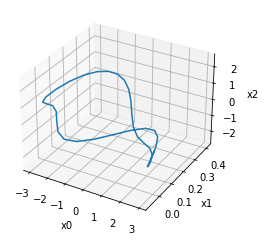

In [4]:
firstVal=3

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.plot(XA[firstVal:,0],XA[firstVal:,1],XA[firstVal:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [5]:
vals=list(map(l3.endptChart,XA[firstVal:,:3]))
Vals=jnp.array(vals)

Text(0.5, 0, 'x2')

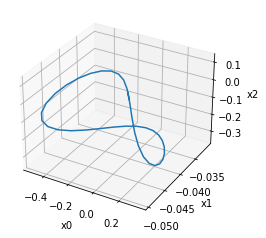

In [6]:
f2 = plt.figure()
a2=f2.add_subplot(projection='3d')
a2.plot(Vals[:,0],Vals[:,1],Vals[:,2])
a2.set_xlabel('x0')
a2.set_ylabel('x1')
a2.set_zlabel('x2')

In [7]:
scipy.io.savemat('./Data/CuspLine_Umbilics.mat', dict(cuspsP=XA[firstVal:,:3], cusps = Vals )) # Matlab export

Location of hyperbolic umbilic bifurcations

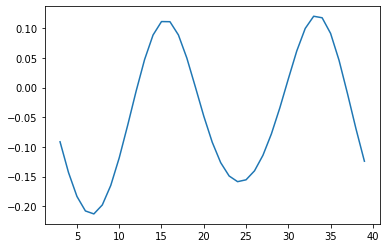

In [8]:
# Plot condition for D series along line of cusps
plt.plot(range(firstVal,N),D2Monitor[firstVal:])

In [9]:
UPre= [XA[13],XA[19],XA[30],XA[38]]

In [10]:
@jit
def CuspAndDCond(Xa):
    
    Jac=jacfwd(l3.endptChart)(Xa[:3])
    
    # cusp
    c1 = jnp.matmul(Jac,Xa[3:]) # first directional derivative
    c2 = (sum(Xa[3:]**2)-1)/ds             # square norm of a
    c3 = jnp.matmul(jvp(lambda q: jnp.matmul(jacfwd(l3.endptChart)(q),Xa[3:]),[Xa[:3]],[Xa[3:]])[1],Xa[3:]) # third directional derivative
    
    # D series
    det2 = -Jac[0, 1]*Jac[1, 0]+Jac[0, 0]*Jac[1, 1]-Jac[0, 2]*Jac[2, 0]-Jac[1, 2]*Jac[2, 1]+Jac[0, 0]*Jac[2, 2]+Jac[1, 1]*Jac[2, 2] # trace of 2nd exterior power
    return jnp.block([c1,c2,c3,det2])
    


In [11]:
for j in range(0,len(UPre)):
    UPre=ops.index_update(UPre,ops.index[j],optimize.fsolve(CuspAndDCond,UPre[j],fprime=jacfwd(CuspAndDCond)))

/home/christianoffen/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [12]:
# Check that optimization has worked
list(map(CuspAndDCond,UPre))

[DeviceArray([ 1.3903736e-09, -5.6184557e-08,  1.3266015e-09,
              -1.1920929e-07,  4.4211808e-09,  1.2369735e-07],            dtype=float32),
 DeviceArray([ 2.1847955e-08, -9.6054855e-08, -2.7680121e-08,
              -1.1920929e-07, -1.8750976e-08,  3.1633355e-08],            dtype=float32),
 DeviceArray([-3.1133459e-07, -1.4425653e-07, -1.4753314e-07,
              -1.1920929e-07, -3.0800962e-07,  3.0585554e-07],            dtype=float32),
 DeviceArray([ 1.10679785e-08,  5.97084835e-08, -2.05204245e-08,
               2.38418579e-07,  3.16073390e-08, -1.26587750e-07],            dtype=float32)]

In [13]:
# location of umbilic bifurcations on locus in chart
U = list(map(l3.endptChart,jnp.array(UPre)[:,:3]))
U

[DeviceArray([-0.40462855, -0.04715793,  0.03189077], dtype=float32),
 DeviceArray([-0.40924558, -0.03829066, -0.32042378], dtype=float32),
 DeviceArray([ 0.25209346, -0.03916778, -0.32564297], dtype=float32),
 DeviceArray([ 0.23155557, -0.04810756,  0.03585111], dtype=float32)]

In [14]:
scipy.io.savemat('./Data/LocationUmbilics.mat', dict(UmbilicLocation=U,UmbilicLocationPreimage=jnp.array(UPre)[:,:3]))

Computation of another cusp line

In [15]:
N = 60
XA = jnp.zeros((N,6))
XA=ops.index_update(XA,ops.index[1],jnp.array([0.092638589628898,0.410963865700726,0.2,-0.986909952758276,-0.049000022941743,0.153648113878325]))

D2Monitor = jnp.zeros(N)

for j in range(1,N):
    XA = ops.index_update(XA,ops.index[j+1],ContFun(XA[j-1],XA[j],cuspCond,ds))
    D2Monitor = ops.index_update(D2Monitor,ops.index[j+1],DCond(XA[j+1,:3]))
    print([j+1,max(abs(cuspCond(XA[j+1]))),float(D2Monitor[j+1])])

[2, 0.8194858, 1.7986242771148682]
[3, 0.7840083, 1.6575334072113037]
[4, 0.7559917, 1.4923028945922852]
[5, 0.73081464, 1.2969918251037598]
[6, 0.7056818, 1.0621401071548462]
[7, 0.6798003, 0.7901431322097778]
[8, 0.6537192, 0.5014464259147644]
[9, 0.62784016, 0.21861109137535095]
[10, 0.60209, -0.041367191821336746]
[11, 0.5765155, -0.26438724994659424]
[12, 0.55121773, -0.43981772661209106]
[13, 0.5261494, -0.5608148574829102]
[14, 0.5011837, -0.6241586208343506]
[15, 0.4762982, -0.6317687034606934]
[16, 1.5621558e-06, 0.1120782271027565]
[17, 2.8545304e-07, 0.13117429614067078]
[18, 1.1153861e-06, 0.15325787663459778]
[19, 3.7342164e-07, 0.17577508091926575]
[20, 4.6589747e-07, 0.19550371170043945]
[21, 4.7877694e-07, 0.2093941867351532]
[22, 4.1318413e-07, 0.21558788418769836]
[23, 3.7359385e-07, 0.2140190601348877]
[24, 1.08633685e-07, 0.20613428950309753]
[25, 4.8182017e-07, 0.19409361481666565]
[26, 2.2740197e-07, 0.18009087443351746]
[27, 3.4950892e-07, 0.16600564122200012]
[2

Text(0.5, 0, 'x2')

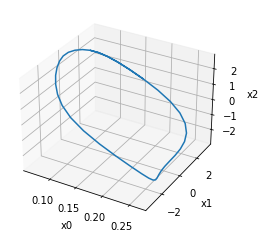

In [16]:
firstVal=16

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.plot(XA[firstVal:,0],XA[firstVal:,1],XA[firstVal:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [17]:
vals=list(map(l3.endptChart,XA[firstVal:,:3]))
Vals=jnp.array(vals)

Text(0.5, 0, 'x2')

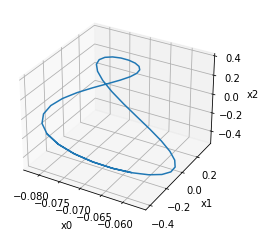

In [18]:
f2 = plt.figure()
a2=f2.add_subplot(projection='3d')
a2.plot(Vals[:,0],Vals[:,1],Vals[:,2])
a2.set_xlabel('x0')
a2.set_ylabel('x1')
a2.set_zlabel('x2')

In [19]:
scipy.io.savemat('./Data/CuspLine_Circle.mat', dict(cuspsP=XA[firstVal:,:3], cusps = Vals )) # Matlab export